# Segmenting and Clustering Neighborhoods in Midrand Johannesburg


## Importing libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from bs4 import BeautifulSoup # this module helps in web scrapping.
import requests  # this module helps us to download a web page

from time import sleep
from random import randint

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>


## 1. Download and Explore Dataset


Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 


For your convenience, I downloaded the files and placed it on the server, so you can simply run a `wget` command and access the data. So let's go ahead and do that.


In [2]:
#initialize lists
location = []
municipal =[]  
district = []
state=[]
postcode=[]

In [3]:
#Defining the scrappper function
def scrapper(webpage, first_page, page_total):

    JoziPages = np.arange(first_page, (page_total+1), 1) #
    for page in JoziPages:
        next_page = webpage + str(page)
        print("URL: ",next_page)
        response = requests.get(str(next_page))
        Jozi_soup = BeautifulSoup(response.text,'html5lib')
        Jozi_data = Jozi_soup.find_all("tr")

        for row in Jozi_data:
            col = row.find_all('td')
            if (col != []): #ignore blank columns
                loc = col[0].text #assign first column to loc
                location.append(loc) #add loc to location list
                #print('location: ',loc)

                muni = col[1].text
                municipal.append(muni)

                distr = col[2].text
                district.append(distr)

                stat = col[3].text
                state.append(stat)

                postc = col[4].text
                postcode.append(postc)

        sleep(randint(2,50))
     


In [5]:
  #calling the function with relevant parameters
  #page has 57 pages (https://www.southafricapostcode.com/location/gauteng/city-of-johannesburg/?page=57)
scrapper('https://www.southafricapostcode.com/location/gauteng/city-of-johannesburg/?page=', 1,8)

### place time delays (2mins) between each scrapping function so not to overload the server

In [7]:
#the lists continues being populated from the last entry
sleep(120) #wait 2mins
scrapper('https://www.southafricapostcode.com/location/gauteng/city-of-johannesburg/?page=', 9,16)
sleep(120) #wait 2mins
scrapper('https://www.southafricapostcode.com/location/gauteng/city-of-johannesburg/?page=', 17,24)
sleep(120) #wait 2mins
scrapper('https://www.southafricapostcode.com/location/gauteng/city-of-johannesburg/?page=', 25,32)
sleep(120) #wait 2mins
scrapper('https://www.southafricapostcode.com/location/gauteng/city-of-johannesburg/?page=', 33,40)
sleep(120) #wait 2mins
scrapper('https://www.southafricapostcode.com/location/gauteng/city-of-johannesburg/?page=', 41,48)
sleep(120) #wait 2mins
scrapper('https://www.southafricapostcode.com/location/gauteng/city-of-johannesburg/?page=', 49,57)

### construct dataframe

In [8]:
Jozi_df = pd.DataFrame({'Location':location,'Municipality':municipal,'District':district,'State':state,'PostCode':postcode})

In [10]:
Jozi_df.head()

,Location,Municipality,District,State,PostCode
0,Abbotsford,NaN,City of Johannesburg,Gauteng,2192
1,Aeroton,NaN,City of Johannesburg,Gauteng,2013
2,Aeroton,NaN,City of Johannesburg,Gauteng,2190
3,Airdlin,NaN,City of Johannesburg,Gauteng,2157
4,Alan Manor,NaN,City of Johannesburg,Gauteng,2091


### save to csv file

In [11]:
#don't save the index
Jozi_df.to_csv('Jozi_PostalCodes.csv', index = False)

## Assign coordinates to Joburg locations

In [12]:
from pandas.io.json import json_normalize
import json
#import googlemaps
import geocoder

API_KEY = "API"
#gmaps = googlemaps.Client(key=API_KEY)

#define lat/long lists
LatsIn = []
LongsIn = []


In [16]:

for index, col_name in Jozi_df.iterrows():
    print(col_name['Location'])
    Lat = geocoder.google("{}, {}, Johannesburg".format(col_name['PostCode'],col_name['Location']), key=API_KEY).lat
    Long = geocoder.google("{}, {}, Johannesburg".format(col_name['PostCode'],col_name['Location']), key=API_KEY).lng

    LatsIn.append(Lat)
    LongsIn.append(Long)


'\nfor index, col_name in Jozi_df.iterrows():\n    print(col_name[\'Location\'])\n    Lat = geocoder.google("{}, {},\xa0Johannesburg".format(col_name[\'PostCode\'],col_name[\'Location\']), key=API_KEY).lat\n    Long = geocoder.google("{}, {},\xa0Johannesburg".format(col_name[\'PostCode\'],col_name[\'Location\']), key=API_KEY).lng\n\n    LatsIn.append(Lat)\n    LongsIn.append(Long)\n    '

### create DF with coords

In [17]:
Jozi_lats = pd.DataFrame({'Lat':LatsIn})

Jozi_longs = pd.DataFrame({'Long':LongsIn})


In [18]:
#join the dataframes
Jozi_combined = Jozi_lats.join(Jozi_longs)
#join coords to the main data
Jozi_df = Jozi_df.join(Jozi_combined)


In [19]:
#drop Municipality
Jozi_df = Jozi_df.drop(['Municipality'],axis=1)


In [20]:
#remove them
Jozi_df.dropna( how='any', inplace=True)


In [21]:
Jozi_df.head()

,Location,District,State,PostCode,Lat,Long
0,Abbotsford,City of Johannesburg,Gauteng,2192,-26.143112,28.066176
1,Aeroton,City of Johannesburg,Gauteng,2013,-26.249736,27.982456
2,Aeroton,City of Johannesburg,Gauteng,2190,-26.249736,27.982456
3,Airdlin,City of Johannesburg,Gauteng,2157,-26.026442,28.060636
4,Alan Manor,City of Johannesburg,Gauteng,2091,-26.278238,27.993722


### save to csv

In [22]:
#don't save the index values
Jozi_df.to_csv("Jozi_coords.csv", index = False)

In [23]:
Jozi_df.shape

(1122, 6)

# Visualize the data

### drop duplicate Locations on the data

In [24]:
#remove all duplicates on postalcode and keep the first duplicate entry
Jozi_data = Jozi_df.drop_duplicates('Location',keep='first')


#save to csv
Jozi_data.to_csv("Jozi_coords_unique.csv")
Jozi_data.shape

(832, 6)

### Get Joburg coordinates

In [25]:
Jozi_Lat = geocoder.google("Johannesburg, South Africa", key=API_KEY).lat
Jozi_Long = geocoder.google("Johannesburg, South Africa", key=API_KEY).lng

print('The geograpical coordinate of Johannesburg City are {}, {}.'.format(Jozi_Lat, Jozi_Long))

The geograpical coordinate of Johannesburg City are -26.2041028, 28.0473051.


### Create map on folium

In [26]:
Jozi_Map = folium.Map(location=[Jozi_Lat, Jozi_Long], zoom_start=12)
# adding in the markers for Jozi neighborhoods
for lat, lng, location in zip(
        Jozi_data['Lat'], 
        Jozi_data['Long'], 
        Jozi_data['Location']):
    label = '{}'.format(location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Jozi_Map)  
# display map
Jozi_Map

### Snapshot
!![title](map4.png)

## Scrap for Municipality data

In [29]:
Municipality_df = pd.DataFrame(columns=['Location','Region'])
Municipality_df.head()

,Location,Region


#### define region urls

In [30]:
RegionA_url = 'https://www.joburg.org.za/about_/regions/Pages/Region%20A%20-%20Diepsloot%2c%20Midrand/suburbs.aspx'
RegionB_url = 'https://www.joburg.org.za/about_/regions/Pages/Region%20B%20-%20Northcliff%20Randurg/suburbs.aspx' #check format, construct separate scrapper function
RegionC_url = 'https://www.joburg.org.za/about_/regions/Pages/Region%20C%20-%20Roodepoort/suburbs.aspx'
RegionD_url = 'https://www.joburg.org.za/about_/regions/Pages/Region%20D%20-%20Greater%20Soweto/suburbs.aspx'
RegionE_url = 'https://www.joburg.org.za/about_/regions/Documents/Region%20E/Region%20E%20Ward%20Location%20%20suburbs%20_.pdf'
RegionF_url = 'https://www.joburg.org.za/about_/regions/Pages/Region%20F%20-%20Inner%20City/Suburbs.aspx' #check format
RegionG_url = 'https://www.joburg.org.za/about_/regions/Pages/Region%20G%20-%20Ennerdale,%20Orange%20Farm/Surburbs.aspx'

#### Function for removing leading/trailing whitespaces
Adapted From: https://www.geeksforgeeks.org/pandas-strip-whitespace-from-entire-dataframe/

In [31]:
def whitespace_remover(dataframe):
    
    # iterating over the columns
    for i in dataframe.columns:
          
        # checking datatype of each columns
        if dataframe[i].dtype == 'object':
              
            # applying strip function on column
            dataframe[i] = dataframe[i].map(str.strip)
        else:
              
            # if condn. is False then it will do nothing.
            pass

#### Function for retrieving Regions A, C, D and G

In [32]:
def Regioner(input_url,municipality):
    region_response = requests.get(input_url)
    region_soup = BeautifulSoup(region_response.text,'html.parser')
    region_rows = region_soup.findAll('div',{'class':'article-content description'})
    Loc = [] 
    Region = []
    for x in region_rows:
        item = x.find_all("td")
        Loc.append(item[0].text.strip().strip(' '))
        #Region.append(item[1].text.strip().replace('Suburbs in ',''))
    
    #make the two lists into dataframes
    test_df = pd.DataFrame(Loc,columns=['Locations'])
    region_df = pd.DataFrame(Region,columns=['Region'])

    #Combine the dataframes
    combined_df = test_df.join(region_df)

    a_df = pd.DataFrame(columns=['Loc','Region'])
    for index, col_name in combined_df.iterrows():        
        loc = col_name['Locations'].strip().split(',')
        #reg = col_name['Region'].strip()
        #a_df = a_df.append({'Loc':loc,'Region':reg},ignore_index=True)    
        a_df = a_df.append({'Loc':loc},ignore_index=True)    
    
    a = pd.DataFrame.from_records( a_df['Loc']).transpose()
    #a[0].str.strip() #remove leading/trailling spaces
    
    b = a.join(a_df['Region'])
   
    #replace NaN values 
    b['Region'].fillna(municipality,inplace=True)
    b.rename(columns={0:'Location'},inplace=True)

    #remove whitespaces
    whitespace_remover(b)
    return b[['Location','Region']]

#### Function for retrieving Region F

In [33]:
def RegionerF(input_url,municipality):
    region_response = requests.get(input_url)
    region_soup = BeautifulSoup(region_response.text,'html.parser')
    region_rows = region_soup.findAll('div',{'class':'article-content description'})

    Loc = [] 
    output_df = pd.DataFrame(columns=['Location','Region'])
    for x in region_rows:
        item = x.find_all("td")
        for i in range(len(item)): #range iterates from 0 to number in range brackets
            Loc.append(item[i].text.strip(',').strip(', ,'))
    #make dataframe from Loc data
    test_df = pd.DataFrame(Loc,columns=['Locations'])

    a_df = pd.DataFrame(columns=['Loc','Region'])
    for index, col_name in test_df.iterrows():    #if you don't do this, items come out in series
        loc = col_name['Locations'].strip().split(',')  
        a_df = a_df.append({'Loc':loc},ignore_index=True)  

    output_df = pd.DataFrame.from_records( a_df['Loc'])
    output_df.rename(columns={0:'Location'},inplace=True)
    output_df = output_df.append({'Region':municipality}, ignore_index=True)
    output_df['Region'].fillna(municipality,inplace=True)

    return output_df

#### Function for retrieving Region B

In [34]:
def RegionerB(input_url,municipality):
    region_response = requests.get(input_url)
    region_soup = BeautifulSoup(region_response.text,'html.parser')
    region_rows = region_soup.findAll('div',{'class':'ms-rtestate-field'})

    output_df = pd.DataFrame(columns=['Location','Region'])
    Loc = [] 
    for x in region_rows:
        item = x.find_all("div") #oddly elements are placed in 'div' and not 'td'
        for i in range(len(item)): #range iterates from 0 to number in range brackets
            Loc.append(item[i].text.strip())

    #make dataframe from Loc data
    output_df = pd.DataFrame(Loc,columns=['Location'])
    output_df = output_df.append({'Region':municipality}, ignore_index=True)
    output_df['Region'].fillna(municipality,inplace=True)

    return output_df

#### Function for retrieving Region E data. This is pdf data that is extracted using camelot

In [35]:
#import libraries
import camelot
import ghostscript

In [36]:
def RegionerE(input_url,municipality):
    #file = "https://www.joburg.org.za/about_/regions/Documents/Region%20E/Region%20E%20Ward%20Location%20%20suburbs%20_.pdf"
    Table_df = pd.DataFrame()
    #read the tables on the file
    tables = camelot.read_pdf(input_url, pages='all' )
    tables

    #check shape of the tables
    for x in range (3):
        Table_df = Table_df.append(tables[x].df,ignore_index = True)

    #clean rows and columns
        #rename columns
    Table_df.rename(columns={0:'Ward',1:'Location'},inplace=True)
    Table_df = Table_df[~Table_df['Ward'].str.contains('WARD')]

    #from https://www.mikulskibartosz.name/how-to-split-a-list-inside-a-dataframe-cell-into-rows-in-pandas/
    # convert 'Location' data into a list (i.e. has [])
    Split_df = pd.DataFrame()
    for col_name in Table_df['Location']:    #if you don't do this, items come out in series
        loc = col_name.split(',')  
        Split_df = Split_df.append({'Loc':loc},ignore_index=True)  

    #Split the comma separated 'Loc' column into new columns
    Split_df = Split_df.Loc.apply(pd.Series)
       

    #merge split and original data
    output_df = Split_df.merge(Table_df, left_index = True, right_index = True).drop(['Location'], axis = 1)

    output_df = output_df.melt(id_vars = ['Ward'], value_name = "Location").dropna().drop("variable", axis = 1)
    output_df = output_df.drop('Ward',axis=1)
    #add region
    output_df['Region'] = municipality
    whitespace_remover(output_df)
    return(output_df)

#### Construct and populate Municipalities table

In [37]:

#delete the contents of df 
Municipality_df = Municipality_df.iloc[0:0]


Municipality_df = Municipality_df.append(Regioner(RegionA_url,'Diepsloot_Midrand'),ignore_index=True)
Municipality_df = Municipality_df.append(RegionerB(RegionB_url,'Northcliff_Randburg'),ignore_index=True)
Municipality_df = Municipality_df.append(Regioner(RegionC_url,'Roodepoort'),ignore_index=True)
Municipality_df = Municipality_df.append(Regioner(RegionD_url,'Soweto'),ignore_index=True)
Municipality_df = Municipality_df.append(Regioner(RegionG_url,'Ennerdale_OrangeFarm'),ignore_index=True)
Municipality_df = Municipality_df.append(RegionerF(RegionF_url,'InnerCity'),ignore_index=True)
Municipality_df = Municipality_df.append(RegionerE(RegionE_url,'Fourways'),ignore_index=True)

"\n#delete the contents of df \nMunicipality_df = Municipality_df.iloc[0:0]\n\n\nMunicipality_df = Municipality_df.append(Regioner(RegionA_url,'Diepsloot_Midrand'),ignore_index=True)\nMunicipality_df = Municipality_df.append(RegionerB(RegionB_url,'Northcliff_Randburg'),ignore_index=True)\nMunicipality_df = Municipality_df.append(Regioner(RegionC_url,'Roodepoort'),ignore_index=True)\nMunicipality_df = Municipality_df.append(Regioner(RegionD_url,'Soweto'),ignore_index=True)\nMunicipality_df = Municipality_df.append(Regioner(RegionG_url,'Ennerdale_OrangeFarm'),ignore_index=True)\nMunicipality_df = Municipality_df.append(RegionerF(RegionF_url,'InnerCity'),ignore_index=True)\nMunicipality_df = Municipality_df.append(RegionerE(RegionE_url,'Fourways'),ignore_index=True)\n"

In [38]:
#### Drop any empty Locations/Municipality
Municipality_df.dropna( how='any', inplace=True)

In [40]:
Municipality_df.head()

,Location,Region
0,​Airdlin,Diepsloot_Midrand
1,Barbeque,Diepsloot_Midrand
2,Barbeque Downs,Diepsloot_Midrand
3,Barbeque Downs Extensions,Diepsloot_Midrand
4,Beverley,Diepsloot_Midrand


In [41]:
#store in csv
Municipality_df.to_csv("Municipalities.csv",index=False)

## Merge Municipalities and Locations

In [42]:
Muni_Loc_df = pd.merge(Jozi_data,Municipality_df,on='Location',how='left')

In [43]:
#drop all non-matched Locations
Muni_Loc_df = pd.DataFrame(Muni_Loc_df.dropna(subset=['Region']))
Muni_Loc_df.head()

,Location,District,State,PostCode,Lat,Long,Region
1,Aeroton,City of Johannesburg,Gauteng,2013,-26.249736,27.982456,InnerCity
10,Allen's Nek,City of Johannesburg,Gauteng,1709,-26.133470,27.909717,Roodepoort
14,Amorosa,City of Johannesburg,Gauteng,1724,-26.100808,27.870703,Roodepoort
15,Anchorville,City of Johannesburg,Gauteng,1827,-26.340688,27.828945,Ennerdale_OrangeFarm
18,Armadale,City of Johannesburg,Gauteng,2013,-26.153074,28.095781,Soweto


In [44]:
Muni_Loc_df.to_csv('Muni_loc.csv',index=False)

#### Group data by Municipality: Northcliff and Randburg excluded

In [45]:
MuniLoc_group = Muni_Loc_df.groupby('Region').count()
MuniLoc_group.head()

,Location,District,State,PostCode,Lat,Long
Region,,,,,,
Diepsloot_Midrand,29,29,29,29,29,29
Ennerdale_OrangeFarm,13,13,13,13,13,13
Fourways,62,62,62,62,62,62
InnerCity,18,18,18,18,18,18
Roodepoort,62,62,62,62,62,62


### Show Distribution of Locations per Region

#### Show cluster distribution of the regions

## Visualize matched Joburg Municipality Locations

In [46]:
Jozi_Map_municipalities = folium.Map(location=[Jozi_Lat, Jozi_Long], zoom_start=12)
# adding in the markers for Toronto neighborhoods
for lat, lng, municipality, location in zip(
        Muni_Loc_df['Lat'], 
        Muni_Loc_df['Long'], 
        Muni_Loc_df['Region'], 
        Muni_Loc_df['Location']):
    label = '{}, {}'.format(location, municipality)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Jozi_Map_municipalities)  

# display map
Jozi_Map_municipalities

### Snapshot
!![title](map5.png)

### Filter data to only show Midrand municipality data

In [47]:
Midrand_Municipality = Muni_Loc_df[Muni_Loc_df['Region'].str.contains("Midrand")].reset_index(drop=True)
Midrand_Municipality.head()

,Location,District,State,PostCode,Lat,Long,Region
0,Barbeque Downs,City of Johannesburg,Gauteng,1684,-26.006963,28.072761,Diepsloot_Midrand
1,Beverley,City of Johannesburg,Gauteng,2191,-26.007799,28.017145,Diepsloot_Midrand
2,Brendavere,City of Johannesburg,Gauteng,2021,-26.015073,27.985670,Diepsloot_Midrand
3,Broadacres,City of Johannesburg,Gauteng,2021,-25.994151,28.012097,Diepsloot_Midrand
4,Buccleuch,City of Johannesburg,Gauteng,2090,-26.057261,28.107827,Diepsloot_Midrand


### Show map with Midrand only

In [48]:
#search for 'Vorna Valley' from the dataframe
Find_vorna = Muni_Loc_df[Muni_Loc_df.eq('Vorna Valley').any(1)]

VornaIndex = [] #list to store returned indexes
# iterating the columns
for row in Find_vorna.index:
    VornaIndex.append(row)


#store the length of indexes returned
VornaLen = len(VornaIndex)

#Get lat and long of Vorna Valley -> use the first index value returned from the search
Vorna_Lat = Muni_Loc_df.loc[VornaIndex[0], 'Lat'] 
Vorna_Long = Muni_Loc_df.loc[VornaIndex[0], 'Long'] 

print(' {} coordinates: {} , {}'.format(Muni_Loc_df.loc[VornaIndex[0],'Location'],Vorna_Lat,Vorna_Long))

 Vorna Valley coordinates: -26.0045638 , 28.1034894


In [49]:
Midrand_map = folium.Map(location=[Vorna_Lat, Vorna_Long], zoom_start=12)
# adding in the markers for Toronto neighborhoods
for lat, lng, region, location in zip(
        Midrand_Municipality['Lat'], 
        Midrand_Municipality['Long'], 
        Midrand_Municipality['Region'], 
        Midrand_Municipality['Location']):
    label = '{}, {}'.format(location, region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Midrand_map)  
# display map
Midrand_map

### Snapshot
!![title](map6.png)

## FourSquare Data

In [50]:
CLIENT_ID = 'client_id' # your Foursquare ID
CLIENT_SECRET = 'client_secret' # your Foursquare Secret
ACCESS_TOKEN = 'access_token' # your FourSquare Access Token
#VERSION = '20180604'
VERSION = '20210523'
LIMIT = 100
RADIUS = 1000

## We sample Vorna Valley as the area of interest

In [51]:
#Generate URL for query
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    Vorna_Lat, 
    Vorna_Long, 
    RADIUS, 
    LIMIT)

In [52]:
#Get response on url request
results = requests.get(url).json()

In [53]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [54]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) 

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,KFC Vorna Valley,Fried Chicken Joint,-26.000346,28.103670
1,Nando's Waterfall Drive Thru,Portuguese Restaurant,-26.011795,28.101204
2,SPAR,Grocery Store,-25.999547,28.103315
3,Pizza Perfect,Pizza Place,-25.999960,28.103589
4,Link Vorna Valley,Pharmacy,-25.999943,28.103069


In [55]:
#count number of returned venues
print('{} venues returned.'.format(nearby_venues.shape[0]))

9 venues returned.


## We now explore all Midrand Location/neighbourhoods

### define the function

In [56]:
# function for getting the venues nearby 
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    
    for name, lat, lng, reg in zip(names, latitudes, longitudes, region):

        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Location', 
                  'Location Latitude', 
                  'Location Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Get venues for all locations

In [57]:
# function to get venues nearby for each Neighborhood
Midrand_df_Venues = getNearbyVenues(names=Midrand_Municipality['Location'],
                                   latitudes=Midrand_Municipality['Lat'],
                                   longitudes=Midrand_Municipality['Long'],
                                  )
Midrand_df_Venues.head()

,Location,Location Latitude,Location Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Barbeque Downs,-26.006963,28.072761,Lory Park Zoo,-26.008954,28.071993,Park
1,Beverley,-26.007799,28.017145,Brazen Head,-26.009169,28.012401,Pub
2,Beverley,-26.007799,28.017145,Rodizio,-26.009597,28.012751,Brazilian Restaurant
3,Beverley,-26.007799,28.017145,Nando's,-26.008733,28.012447,Portuguese Restaurant
4,Beverley,-26.007799,28.017145,Banjaara,-26.008527,28.012971,Indian Restaurant


In [58]:
#save to csv
Midrand_df_Venues.to_csv("MidrandVenues.csv, index=False")

In [59]:
# group by neighborhood
Midrand_df_Venues.groupby('Location').count()

,Location Latitude,Location Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Location,,,,,,
Barbeque Downs,1,1,1,1,1,1
Beverley,6,6,6,6,6,6
Brendavere,1,1,1,1,1,1
Broadacres,13,13,13,13,13,13
Buccleuch,4,4,4,4,4,4
Carlswald,23,23,23,23,23,23
Chartwell,2,2,2,2,2,2
Country View,1,1,1,1,1,1
Craigavon,10,10,10,10,10,10


In [60]:
#count of unique categories
print('{} uniques categories.'.format(len(Midrand_df_Venues['Venue Category'].unique())))

50 uniques categories.


### Analyse each Location

In [61]:
Midrand_df_Venues['Location'].head()

0    Barbeque Downs
1          Beverley
2          Beverley
3          Beverley
4          Beverley
Name: Location, dtype: object

#### One hot encoding

In [62]:
Midrand_df_onehot = pd.get_dummies(Midrand_df_Venues[['Venue Category']], prefix="", prefix_sep="")
#Midrand_df_onehot.drop(['Location'],axis=1,inplace=True) 
Midrand_df_onehot.insert(loc=0, column='Location', value=Midrand_df_Venues['Location'] )
Midrand_df_onehot.shape

(80, 51)

In [63]:
Midrand_group = Midrand_df_onehot.groupby('Location').mean().reset_index()
Midrand_group.head()

,Location,African Restaurant,Animal Shelter,Asian Restaurant,Automotive Shop,BBQ Joint,Bakery,Basketball Court,Bed & Breakfast,Brazilian Restaurant,Breakfast Spot,Burger Joint,Café,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Cosmetics Shop,Dog Run,Fast Food Restaurant,Food Court,Food Service,Fried Chicken Joint,Furniture / Home Store,Gas Station,Grocery Store,Gym,Gym / Fitness Center,Historic Site,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,Office,Optical Shop,Other Great Outdoors,Park,Pet Store,Pharmacy,Pizza Place,Plaza,Portuguese Restaurant,Pub,Restaurant,Scenic Lookout,Seafood Restaurant,Shopping Mall,Spa,Stables,Steakhouse,Supermarket
0,Barbeque Downs,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,Beverley,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.166667,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.166667,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.166667,0.000000,0.000000,0.0,0.166667,0.166667,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
2,Brendavere,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
3,Broadacres,0.0,0.0,0.153846,0.0,0.0,0.076923,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.000000,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.000000,0.076923,0.076923,0.0,0.000000,0.000000,0.076923,0.0,0.076923,0.153846,0.0,0.0,0.076923,0.076923
4,Buccleuch,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.250000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.250000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.250000,0.0,0.0,0.000000,0.000000


### Store values in dataframe

In [64]:
#define function
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [65]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Location']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Midrand_venues_sorted = pd.DataFrame(columns=columns)
Midrand_venues_sorted['Location'] = Midrand_group['Location']

for ind in np.arange(Midrand_group.shape[0]):
    Midrand_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Midrand_group.iloc[ind, :], num_top_venues)

Midrand_venues_sorted.head()

,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barbeque Downs,Park,African Restaurant,Pharmacy,Historic Site,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,Office,Optical Shop
1,Beverley,Indian Restaurant,Brazilian Restaurant,Pub,Portuguese Restaurant,Chinese Restaurant,Pet Store,African Restaurant,Pharmacy,Italian Restaurant,Japanese Restaurant
2,Brendavere,Office,African Restaurant,Pharmacy,Historic Site,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,Optical Shop,Other Great Outdoors
3,Broadacres,Shopping Mall,Asian Restaurant,Supermarket,Pharmacy,Pizza Place,Gym / Fitness Center,Restaurant,Seafood Restaurant,Bakery,Steakhouse
4,Buccleuch,Pizza Place,Indian Restaurant,Shopping Mall,Dog Run,Pharmacy,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,Office,Optical Shop


# Clustering of Locations

In [66]:
# set number of clusters to 3, these will be High, Medium and Low density venue areas
kclusters = 3

Midrand_group_clustering = Midrand_group.drop('Location', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Midrand_group_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 1, 2, 1, 1, 1, 1, 1, 1, 1])

In [67]:

# add clustering labels
Midrand_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Midrand_merged = Midrand_Municipality

# merge Jozi_grouped with Jozi_df to add latitude/longitude for each Location
Midrand_merged = Midrand_merged.join(Midrand_venues_sorted.set_index('Location'), on='Location')

Midrand_merged.head() # check the last columns!

,Location,District,State,PostCode,Lat,Long,Region,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barbeque Downs,City of Johannesburg,Gauteng,1684,-26.006963,28.072761,Diepsloot_Midrand,0.0,Park,African Restaurant,Pharmacy,Historic Site,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,Office,Optical Shop
1,Beverley,City of Johannesburg,Gauteng,2191,-26.007799,28.017145,Diepsloot_Midrand,1.0,Indian Restaurant,Brazilian Restaurant,Pub,Portuguese Restaurant,Chinese Restaurant,Pet Store,African Restaurant,Pharmacy,Italian Restaurant,Japanese Restaurant
2,Brendavere,City of Johannesburg,Gauteng,2021,-26.015073,27.985670,Diepsloot_Midrand,2.0,Office,African Restaurant,Pharmacy,Historic Site,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,Optical Shop,Other Great Outdoors
3,Broadacres,City of Johannesburg,Gauteng,2021,-25.994151,28.012097,Diepsloot_Midrand,1.0,Shopping Mall,Asian Restaurant,Supermarket,Pharmacy,Pizza Place,Gym / Fitness Center,Restaurant,Seafood Restaurant,Bakery,Steakhouse
4,Buccleuch,City of Johannesburg,Gauteng,2090,-26.057261,28.107827,Diepsloot_Midrand,1.0,Pizza Place,Indian Restaurant,Shopping Mall,Dog Run,Pharmacy,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,Office,Optical Shop


In [68]:
#save to csv
Midrand_merged.to_csv("MidrandMerged.csv")

In [69]:
#clean 'Cluster Labels' they need to be integer with no nulls
#Check if any NaN/Null values
print(Midrand_merged.isnull().sum())

Location                   0
District                   0
State                      0
PostCode                   0
Lat                        0
Long                       0
Region                     0
Cluster Labels            13
1st Most Common Venue     13
2nd Most Common Venue     13
3rd Most Common Venue     13
4th Most Common Venue     13
5th Most Common Venue     13
6th Most Common Venue     13
7th Most Common Venue     13
8th Most Common Venue     13
9th Most Common Venue     13
10th Most Common Venue    13
dtype: int64


In [70]:
#drop nulls
Midrand_merged.dropna( how='any', inplace=True)
print(Midrand_merged.isnull().sum())

Location                  0
District                  0
State                     0
PostCode                  0
Lat                       0
Long                      0
Region                    0
Cluster Labels            0
1st Most Common Venue     0
2nd Most Common Venue     0
3rd Most Common Venue     0
4th Most Common Venue     0
5th Most Common Venue     0
6th Most Common Venue     0
7th Most Common Venue     0
8th Most Common Venue     0
9th Most Common Venue     0
10th Most Common Venue    0
dtype: int64


In [71]:
Midrand_merged.dtypes

Location                   object
District                   object
State                      object
PostCode                    int64
Lat                       float64
Long                      float64
Region                     object
Cluster Labels            float64
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

In [72]:
#convert to 'Cluster Labels' to Int
Midrand_merged['Cluster Labels'] = Midrand_merged['Cluster Labels'].astype(int)
Midrand_merged.dtypes

Location                   object
District                   object
State                      object
PostCode                    int64
Lat                       float64
Long                      float64
Region                     object
Cluster Labels              int32
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

### Display on folium

In [73]:
# create map
Midrand_ClusterMap = folium.Map(location=[Vorna_Lat, Vorna_Long], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Midrand_merged['Lat'], Midrand_merged['Long'], Midrand_merged['Location'], Midrand_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' (Cluster ' + str(cluster) +')', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(Midrand_ClusterMap)
       
Midrand_ClusterMap

### Snapshot
!![title](map7.png)

# Examine each cluster

In [74]:
print(Midrand_merged.shape)

(16, 18)


In [75]:
#find 
print(Midrand_merged.filter(regex='1st Most Common Venue').columns)

Index(['1st Most Common Venue'], dtype='object')


In [76]:

# find the index number for first classification
index_no = Midrand_merged.columns.get_loc('1st Most Common Venue')
ClusterLabels_index = Midrand_merged.columns.get_loc('Cluster Labels')

# Review: Cluster Summary

### Use word cloud to analyze each cluster

In [77]:
# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)
stopwords.add('Restaurant') # add the word Restaurant to stopwords

In [78]:
#print('Cluster 0 has: ',len(Midrand_merged.loc[Midrand_merged['Cluster Labels'] == 0]), ' Venues')
#print('Cluster 1 has: ',len(Midrand_merged.loc[Midrand_merged['Cluster Labels'] == 1]), ' Venues')
#print('Cluster 2 has: ',len(Midrand_merged.loc[Midrand_merged['Cluster Labels'] == 2]), ' Venues')

cluster_df = pd.DataFrame(columns=['Cluster','Venues'])
for x in range(3):
    venue = len(Midrand_merged.loc[Midrand_merged['Cluster Labels'] == x])
    cluster_df = cluster_df.append({'Cluster':x,'Venues':venue},ignore_index=True)
cluster_df.head()

,Cluster,Venues
0,0,1
1,1,14
2,2,1


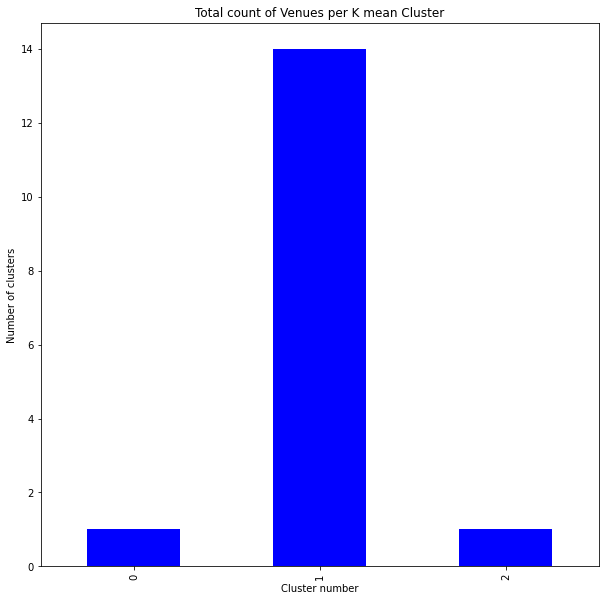

In [79]:
# generate plot
cluster_df['Venues'].plot(kind='bar', figsize=(10,10), color='blue')
plt.xlabel('Cluster number')
plt.ylabel('Number of clusters')
plt.title('Total count of Venues per K mean Cluster')


plt.show()

### Cluster 0 venue distribution

In [80]:
Midrand_merged.loc[Midrand_merged['Cluster Labels'] == 0, Midrand_merged.columns[ list(range(index_no, Midrand_merged.shape[1],1))]]

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Park,African Restaurant,Pharmacy,Historic Site,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,Office,Optical Shop


In [81]:
cluster0_words = Midrand_merged.loc[Midrand_merged['Cluster Labels'] == 0, Midrand_merged.columns[list(range(index_no, Midrand_merged.shape[1],1))]].to_string(header=False, index=False)

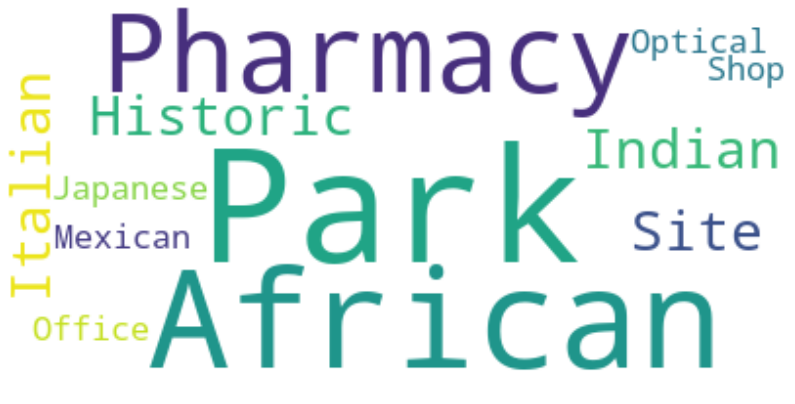

In [82]:
# instantiate a word cloud object
cluster0_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
cluster0_wc.generate(cluster0_words)
# display the cloud
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

plt.imshow(cluster0_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## Cluster 1 venue distribution

In [83]:
Midrand_merged.loc[Midrand_merged['Cluster Labels'] == 1, Midrand_merged.columns[[0] + [ClusterLabels_index] + list(range(index_no, Midrand_merged.shape[1],1))]]

,Location,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Beverley,1,Indian Restaurant,Brazilian Restaurant,Pub,Portuguese Restaurant,Chinese Restaurant,Pet Store,African Restaurant,Pharmacy,Italian Restaurant,Japanese Restaurant
3,Broadacres,1,Shopping Mall,Asian Restaurant,Supermarket,Pharmacy,Pizza Place,Gym / Fitness Center,Restaurant,Seafood Restaurant,Bakery,Steakhouse
4,Buccleuch,1,Pizza Place,Indian Restaurant,Shopping Mall,Dog Run,Pharmacy,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,Office,Optical Shop
5,Carlswald,1,Clothing Store,Indian Restaurant,Furniture / Home Store,Fast Food Restaurant,Seafood Restaurant,Supermarket,Pet Store,Pizza Place,Portuguese Restaurant,Cosmetics Shop
6,Chartwell,1,Stables,Spa,African Restaurant,Pet Store,Historic Site,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,Office
7,Country View,1,Basketball Court,African Restaurant,Pizza Place,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,Office,Optical Shop,Other Great Outdoors
8,Craigavon,1,Café,Fast Food Restaurant,Plaza,Fried Chicken Joint,Scenic Lookout,Breakfast Spot,Portuguese Restaurant,Historic Site,Pet Store,Italian Restaurant
9,Crowthorne,1,Italian Restaurant,Food Service,African Restaurant,Pharmacy,Indian Restaurant,Japanese Restaurant,Mexican Restaurant,Office,Optical Shop,Other Great Outdoors
10,Dainfern,1,Gym / Fitness Center,Other Great Outdoors,Animal Shelter,Pharmacy,Historic Site,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,Office
11,Dainfern Ridge,1,Gym,Asian Restaurant,Pizza Place,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,Office,Optical Shop,Other Great Outdoors


In [84]:
cluster1_words = Midrand_merged.loc[Midrand_merged['Cluster Labels'] == 1, Midrand_merged.columns[list(range(index_no, Midrand_merged.shape[1],1))]].to_string(header=False, index=False)

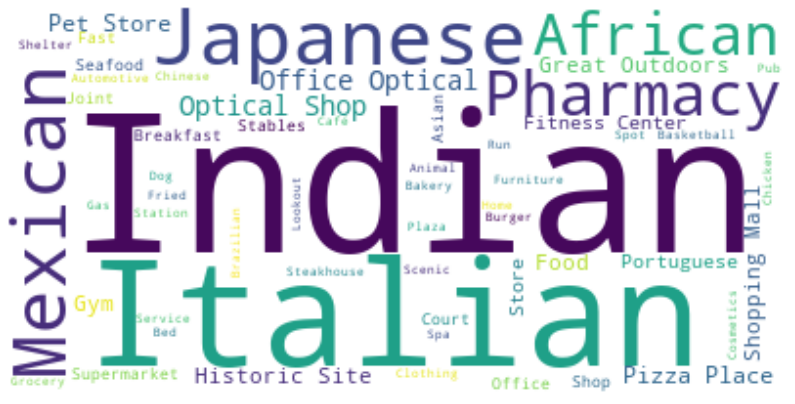

In [85]:
# instantiate a word cloud object
cluster1_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
cluster1_wc.generate(cluster1_words)
# display the cloud
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

plt.imshow(cluster1_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## Cluster 2 venue distribution

In [86]:
Midrand_merged.loc[Midrand_merged['Cluster Labels'] == 2, Midrand_merged.columns[[0] + [ClusterLabels_index] + list(range(index_no, Midrand_merged.shape[1],1))]]

,Location,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Brendavere,2,Office,African Restaurant,Pharmacy,Historic Site,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Mexican Restaurant,Optical Shop,Other Great Outdoors


In [87]:
cluster2_words = Midrand_merged.loc[Midrand_merged['Cluster Labels'] == 2, Midrand_merged.columns[list(range(index_no, Midrand_merged.shape[1],1))]].to_string(header=False, index=False)

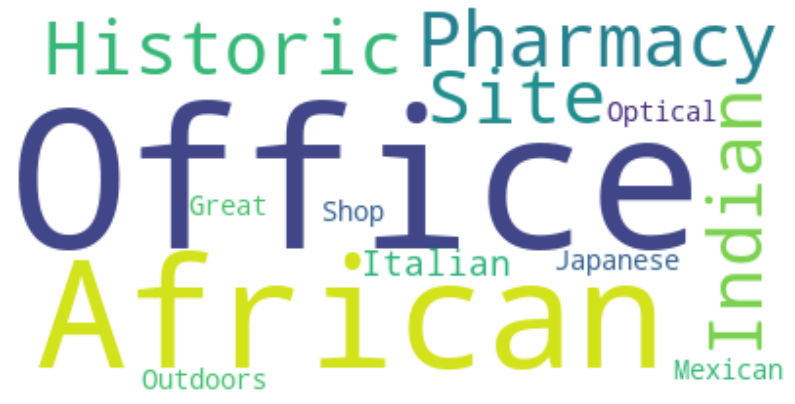

In [88]:
# instantiate a word cloud object
cluster2_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
cluster2_wc.generate(cluster2_words)
# display the cloud
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

plt.imshow(cluster2_wc, interpolation='bilinear')
plt.axis('off')
plt.show()